In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [6]:
data = pd.read_csv('feb-20-us-flight-delay.csv')


In [7]:

data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE,Unnamed: 9
0,2,1,6,MQ,CLT,LYH,1430.0,0.0,175.0,NaN
1,2,8,6,MQ,CLT,LYH,1442.0,0.0,175.0,NaN
2,2,13,4,MQ,DFW,SHV,2247.0,0.0,190.0,NaN
3,2,14,5,MQ,DFW,SHV,2230.0,0.0,190.0,NaN
4,2,15,6,MQ,DFW,SHV,2246.0,0.0,190.0,NaN


In [8]:
data = data.drop(['Unnamed: 9'], axis=1)

In [10]:
data['DEP_DEL15'].value_counts()



0.0    487135
1.0     82182
Name: DEP_DEL15, dtype: int64

In [11]:
# Split the data into positive and negative
positive_rows = data.DEP_DEL15 == 1.0
data_pos = data.loc[positive_rows]
data_neg = data.loc[~positive_rows]

# Merge the balanced data
data = pd.concat([data_pos, data_neg.sample(n = len(data_pos))], axis = 0)

# Shuffle the order of data
data = data.sample(n = len(data)).reset_index(drop = True)

In [12]:
data.isna().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
OP_UNIQUE_CARRIER      0
ORIGIN                 0
DEST                   0
DEP_TIME             816
DEP_DEL15            817
DISTANCE               0
dtype: int64

In [13]:
data = data.dropna(axis=0)

In [14]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 163547 entries, 0 to 164363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              163547 non-null  int64  
 1   DAY_OF_MONTH       163547 non-null  int64  
 2   DAY_OF_WEEK        163547 non-null  int64  
 3   OP_UNIQUE_CARRIER  163547 non-null  object 
 4   ORIGIN             163547 non-null  object 
 5   DEST               163547 non-null  object 
 6   DEP_TIME           163547 non-null  float64
 7   DEP_DEL15          163547 non-null  float64
 8   DISTANCE           163547 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 12.5+ MB


In [15]:
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)

In [16]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns in our dataset.")

There are 163547 rows and 9 columns in our dataset.


In [17]:
data.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DEL15,DISTANCE
count,163547.0,163547.000000,163547.000000,163547.000000,163547.000000,163547.000000
mean,2.0,14.808440,4.013189,1416.469645,0.502498,793.112402
std,0.0,8.173661,1.917978,498.030483,0.499995,575.277589
min,2.0,1.000000,1.000000,1.000000,0.000000,31.000000
25%,2.0,7.000000,2.000000,1026.000000,0.000000,370.000000
50%,2.0,14.000000,4.000000,1437.000000,1.000000,645.000000
75%,2.0,22.000000,6.000000,1826.000000,1.000000,1035.000000
max,2.0,29.000000,7.000000,2400.000000,1.000000,5095.000000


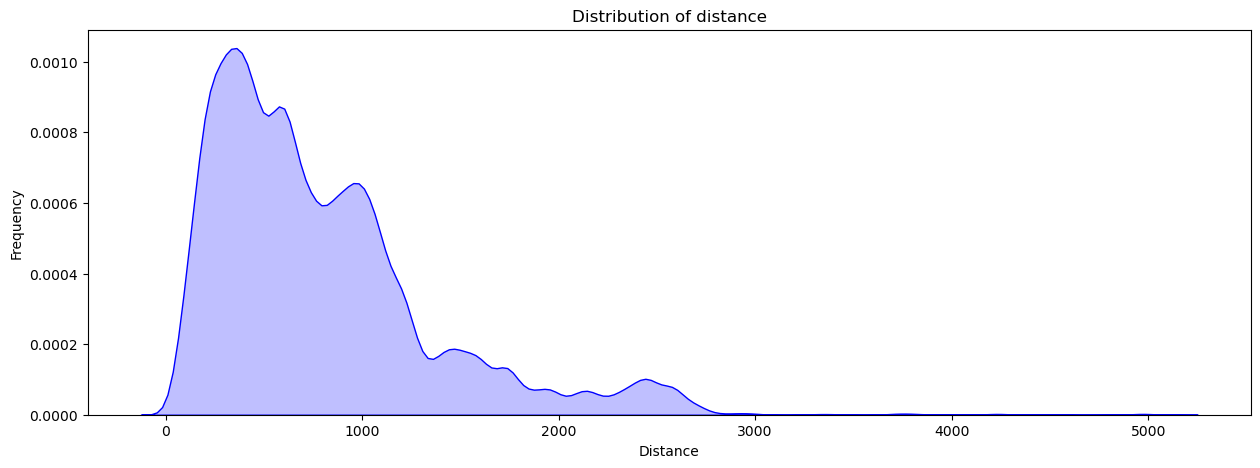

In [18]:
plt.figure(figsize=(15,5))
sns.distplot(data['DISTANCE'], hist=False, color="b", kde_kws={"shade": True})
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of distance")
plt.show()

In [20]:
print(f"Average distance if there is a delay {data[data['DEP_DEL15'] == 1]['DISTANCE'].values.mean()} miles")
print(f"Average distance if there is no delay {data[data['DEP_DEL15'] == 0]['DISTANCE'].values.mean()} miles")

Average distance if there is a delay 786.1071280815751 miles
Average distance if there is no delay 800.1880169606096 miles


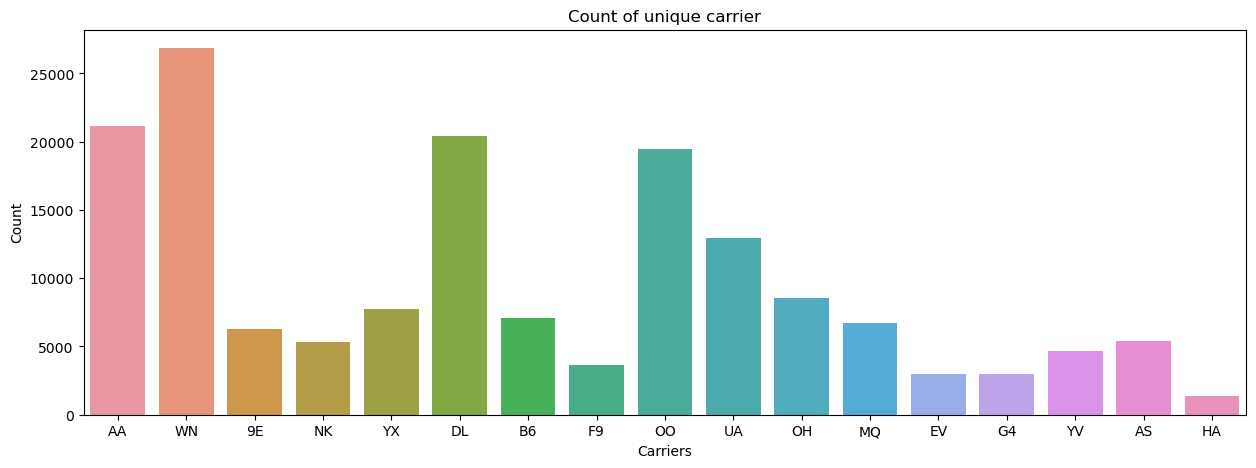

In [21]:
plt.figure(figsize=(15,5))
sns.countplot(x=data['OP_UNIQUE_CARRIER'], data=data)
plt.xlabel("Carriers")
plt.ylabel("Count")
plt.title("Count of unique carrier")
plt.show()

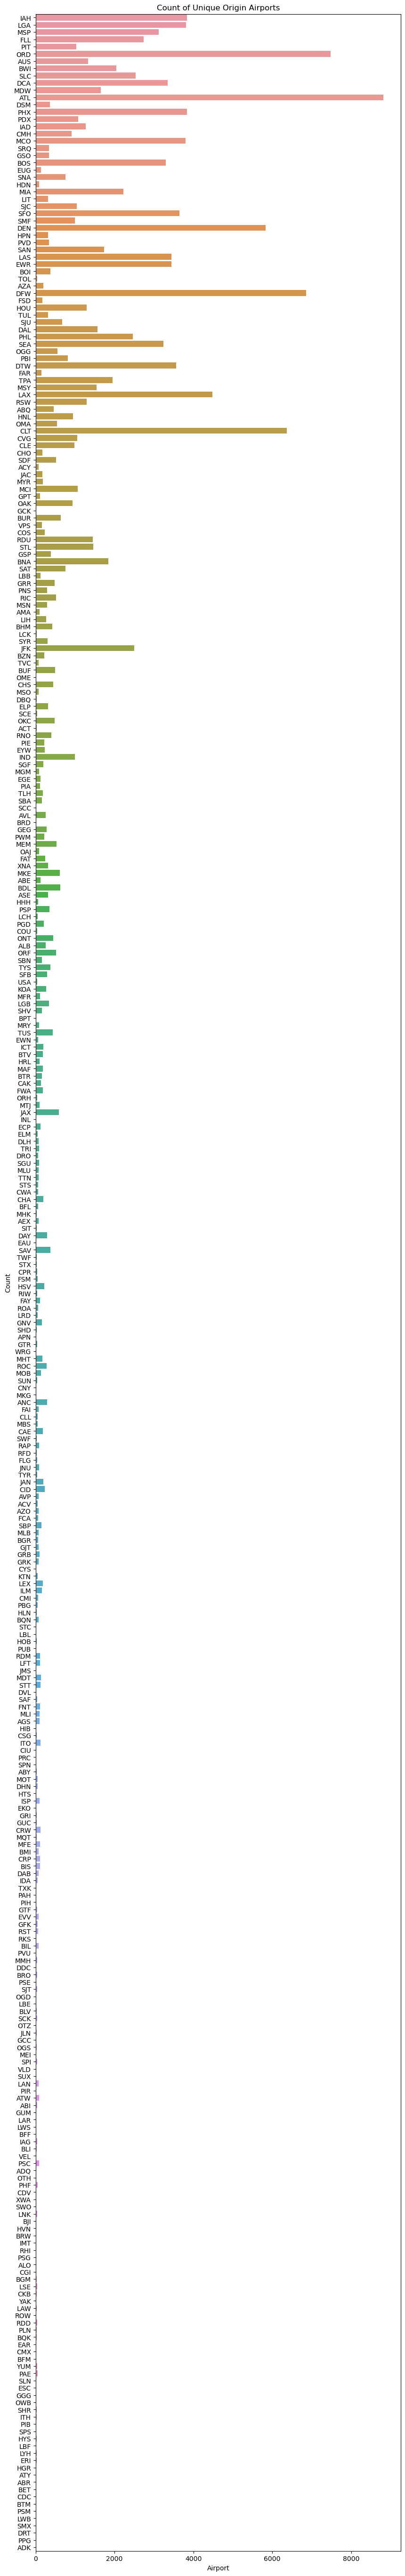

In [22]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['ORIGIN'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Origin Airports")
plt.show()

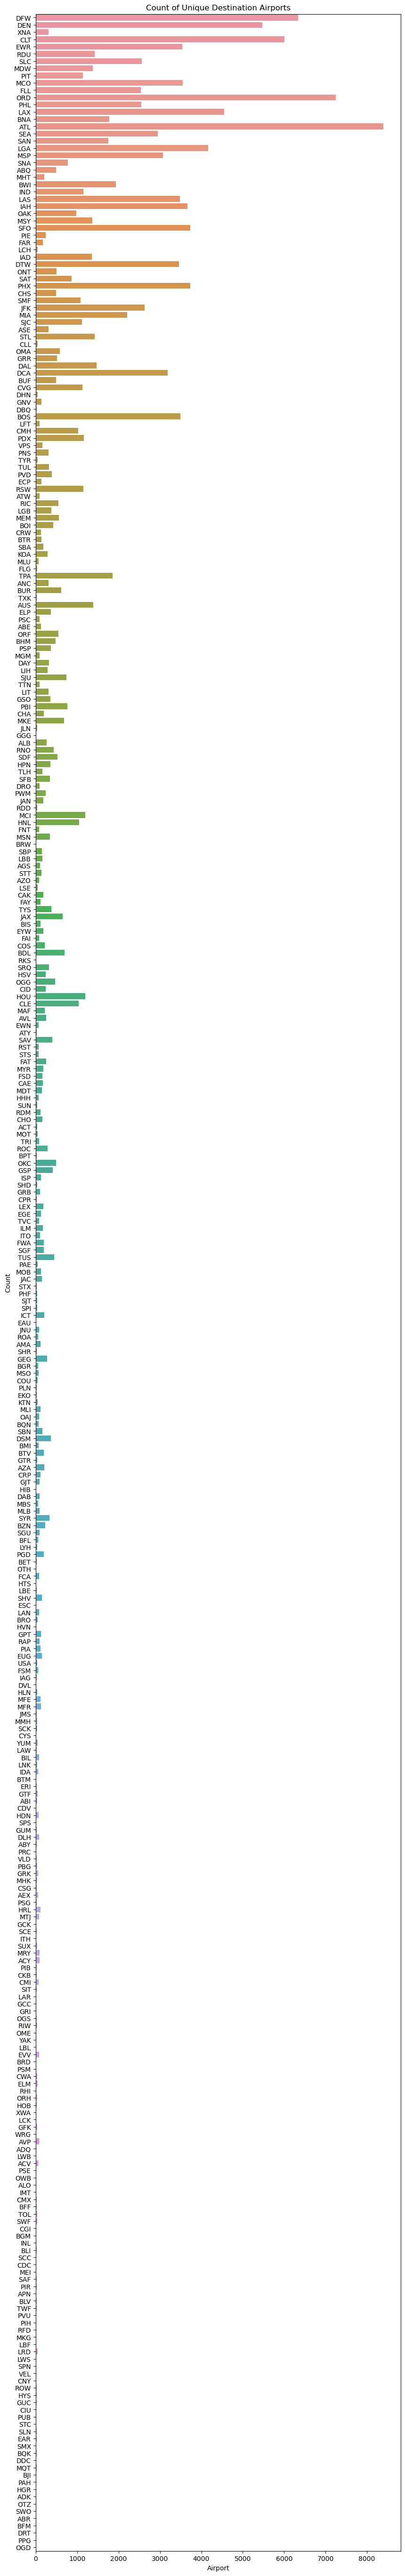

In [23]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['DEST'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Destination Airports")
plt.show()

In [24]:
data = data.rename(columns={'DEP_DEL15':'TARGET'})

In [25]:
def label_encoding(categories):
    """
    To perform mapping of categorical features
    """
    categories = list(set(list(categories.values)))
    mapping = {}
    for idx in range(len(categories)):
        mapping[categories[idx]] = idx
    return mapping

In [26]:
data['OP_UNIQUE_CARRIER'] = data['OP_UNIQUE_CARRIER'].map(label_encoding(data['OP_UNIQUE_CARRIER']))

In [27]:
data['ORIGIN'] = data['ORIGIN'].map(label_encoding(data['ORIGIN']))


In [28]:
data['DEST'] = data['DEST'].map(label_encoding(data['DEST']))

In [29]:
data.head()


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,TARGET,DISTANCE
0,2,3,1,16,62,296,1656.0,1,224.0
1,2,17,1,11,305,179,1630.0,1,1620.0
2,2,3,1,1,227,203,1201.0,1,596.0
3,2,14,5,5,54,36,2250.0,1,632.0
4,2,28,5,10,260,300,1603.0,0,319.0


In [30]:
data['TARGET'].value_counts()

1    82182
0    81365
Name: TARGET, dtype: int64

In [31]:
X = data[['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME', 'DISTANCE']].values
y = data[['TARGET']].values

In [32]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=41)

# Splitting Train-set and Validation-set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=41)

In [33]:
def get_accuracy(y_true, y_preds):
    # Getting score of confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_preds).ravel()
    # Calculating accuracy
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    return accuracy

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [36]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [37]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [38]:
models = [lr,gnb, rf, knn]
acc = []
for model in models:
    preds_val = model.predict(X_val)
    accuracy = get_accuracy(y_val, preds_val)
    acc.append(accuracy)

In [39]:
model_name = ['Logistic Regression',  'Naive Bayes', 'Random Forest', 'KNN']
accuracy = dict(zip(model_name, acc))

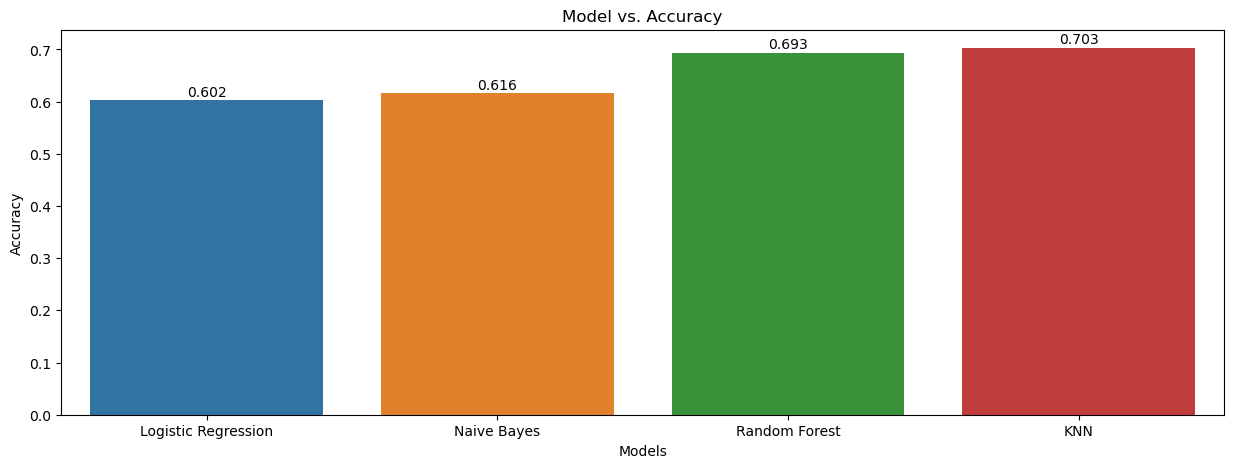

In [40]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

In [41]:
test_preds = knn.predict(X_test)
get_accuracy(y_test, test_preds)

0.6904922042188933

In [42]:
leaf_size = list(range(1,5))
n_neighbors = list(range(1,3))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_2 = KNeighborsClassifier()

clf = GridSearchCV(knn_2, hyperparameters, cv=2)

best_model = clf.fit(X_train,y_train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


In [43]:
knn_best = KNeighborsClassifier(leaf_size=3, p=1, n_neighbors=1)

In [44]:
knn_best.fit(X_train, y_train)
test_preds_1 = knn_best.predict(X_test)

In [45]:
get_accuracy(y_test, test_preds_1)

0.7585447875267503